In [1]:
import tensorflow as tf 
import torch 
import numpy as np 
import torchvision 
import torch.nn.functional as F 
from torch import nn, optim 
from torchvision import transforms, datasets 

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 

In [2]:
EPOCH = 10 
BATCH_SIZE = 64 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(f"Status device: {DEVICE}")

Status device: cuda


In [4]:
trainset = datasets.FashionMNIST(
    root = './data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
trainloader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [13]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12,3)
    )
    self.decoder = nn.Sequential(
        nn.Linear(3, 12),
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28),
        nn.Sigmoid(), # 픽셀값이 모두 0~1값이니까 사용 
    )
  def forward(self, x):
    encoded = self.encoder(x) # first make a encoded variable 
    decoded = self.decoder(encoded) # make a recovered result
    return encoded, decoded 

In [14]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(),lr=0.005)

critierion = nn.MSELoss() # mse using for autoencoder performance 

In [15]:
view_data = trainset.data[:5].view(-1, 28*28) # one good thing of pytorch is accessing loader with key value 
view_data = view_data.type(torch.FloatTensor)/255 # normalize pixel 

In [16]:
def train(autoencoder, train_loader):
  autoencoder.train() # model is about to train (get ready)
  for step , (x, label) in enumerate(train_loader):
    x = x.view(-1, 28*28).to(DEVICE)
    y = x.view(-1, 28*28).to(DEVICE) # autoencoder's label is same as x (input data) 

    label = label.to(DEVICE)
    encoded , decoded = autoencoder(x) # get latent vector(encoded), decoded value 
    loss = critierion(decoded, y) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # simple backward implementation 
    

1th epoch 


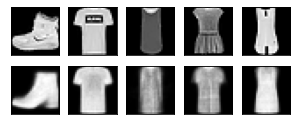

2th epoch 


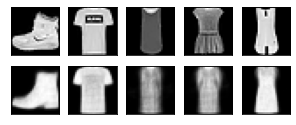

3th epoch 


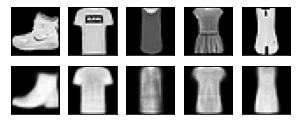

4th epoch 


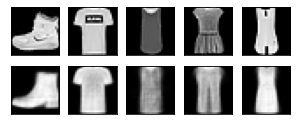

5th epoch 


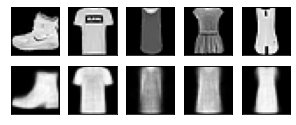

6th epoch 


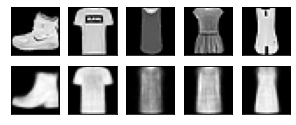

7th epoch 


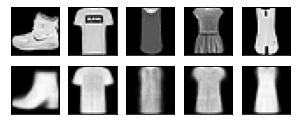

8th epoch 


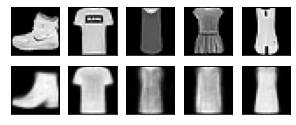

9th epoch 


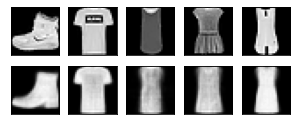

10th epoch 


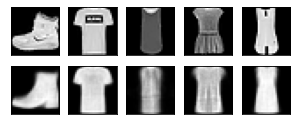

In [18]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, trainloader)
    test_x = view_data.to(DEVICE) # image for testing 
    
    _, decoded_data = autoencoder(test_x) 

    f,a = plt.subplots(2,5,figsize=(5,2))
    print(f"{epoch}th epoch ")
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28,28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) 
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

In [19]:
# making a noise for testing how autoencoder is good 
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2 
    noisy_img = img + noise 
    return noisy_img 

In [22]:
def train_noise(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0 
    for step , (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x)
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)

        loss = critierion(decoded , y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() # pytorch so we extract pure value by using .item() 
    return avg_loss / len(train_loader)

In [23]:
for i in range(1, EPOCH+1):
    loss = train_noise(autoencoder, trainloader)
    print(f"{epoch} epoch : {loss} loss")

10 epoch : 0.022437812643312315 loss
10 epoch : 0.021893355669751605 loss
10 epoch : 0.021936346838342103 loss
10 epoch : 0.021795987592402425 loss
10 epoch : 0.021723732525018104 loss
10 epoch : 0.021679132976241584 loss
10 epoch : 0.021661337836385408 loss
10 epoch : 0.021671585782345678 loss
10 epoch : 0.021503709566427956 loss
10 epoch : 0.021607762619630613 loss


In [24]:
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False, 
    download  = True,
    transform = transforms.ToTensor()
)


sample_data = testset.data[0].view(-1, 28*28) 
sample_data = sample_data.type(torch.FloatTensor)/255.

original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x) 

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



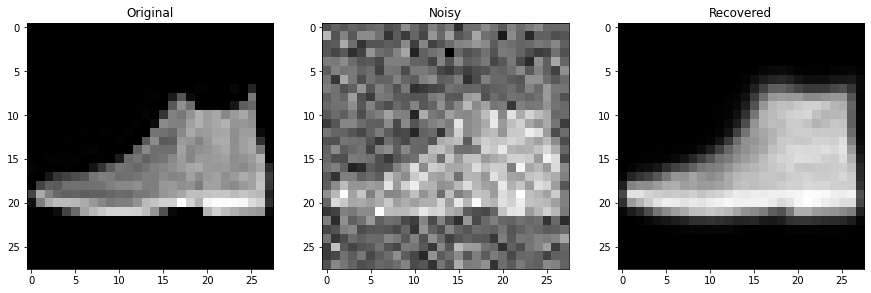

In [25]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()